In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=" * 60)
print("PREDICTIVE ANALYTICS FOR RESOURCE ALLOCATION")
print("=" * 60)


PREDICTIVE ANALYTICS FOR RESOURCE ALLOCATION


In [3]:
#Manual file upload, too big switched to kaggle loading
from google.colab import files
uploaded = files.upload()

Saving breast_cancer.csv to breast_cancer.csv


In [4]:
print("\n1. Loading and Preparing Data...")
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['diagnosis'] = data.target


1. Loading and Preparing Data...


In [6]:
def create_priorities(df):
    priorities = []
    # Normalize key features
    size_score = (df['mean radius'] - df['mean radius'].min()) / (df['mean radius'].max() - df['mean radius'].min())
    severity_score = (df['worst concave points'] - df['worst concave points'].min()) / (df['worst concave points'].max() - df['worst concave points'].min())

    for i, row in df.iterrows():
        if row['diagnosis'] == 0:  # Malignant
            if severity_score.iloc[i] > 0.6:
                priorities.append('High')
            else:
                priorities.append('Medium')
        else:  # Benign
            if size_score.iloc[i] > 0.7:
                priorities.append('Medium')
            else:
                priorities.append('Low')
    return priorities

df['priority'] = create_priorities(df)
print(f"Dataset: {df.shape[0]} samples, {df.shape[1]-2} features")
print("Priority Distribution:", df['priority'].value_counts().to_dict())
print("\n2. Feature Selection and Preprocessing...")
# Select key features
features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
           'mean compactness', 'mean concavity', 'worst radius', 'worst texture',
           'worst perimeter', 'worst concave points']

X = df[features]
y = df['priority']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {len(X_train)} samples, Testing: {len(X_test)} samples")



Dataset: 569 samples, 30 features
Priority Distribution: {'Low': 357, 'High': 119, 'Medium': 93}

2. Feature Selection and Preprocessing...
Training: 455 samples, Testing: 114 samples


In [7]:
print("\n3. Training Random Forest Model...")
rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
rf.fit(X_train_scaled, y_train)



3. Training Random Forest Model...


RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

In [8]:
print("\n4. Model Evaluation...")
y_pred = rf.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# Cross-validation
cv_accuracy = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='accuracy')
cv_f1 = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='f1_macro')

print(f"CV Accuracy: {cv_accuracy.mean():.4f} (±{cv_accuracy.std()*2:.4f})")
print(f"CV F1-Score: {cv_f1.mean():.4f} (±{cv_f1.std()*2:.4f})")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 5. FEATURE IMPORTANCE
print("\n5. Feature Importance (Top 5):")
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

for _, row in feature_importance.head().iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")



4. Model Evaluation...
Test Accuracy: 0.9825
Test F1-Score: 0.9769
CV Accuracy: 0.9648 (±0.0256)
CV F1-Score: 0.9526 (±0.0354)

Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        24
         Low       0.97      1.00      0.99        71
      Medium       1.00      0.89      0.94        19

    accuracy                           0.98       114
   macro avg       0.99      0.96      0.98       114
weighted avg       0.98      0.98      0.98       114


5. Feature Importance (Top 5):
  worst concave points: 0.3344
  worst radius: 0.1845
  worst perimeter: 0.1766
  mean concavity: 0.0935
  mean area: 0.0449



6. Creating Visualizations...


Text(0.5, 1.0, 'Confusion Matrix')

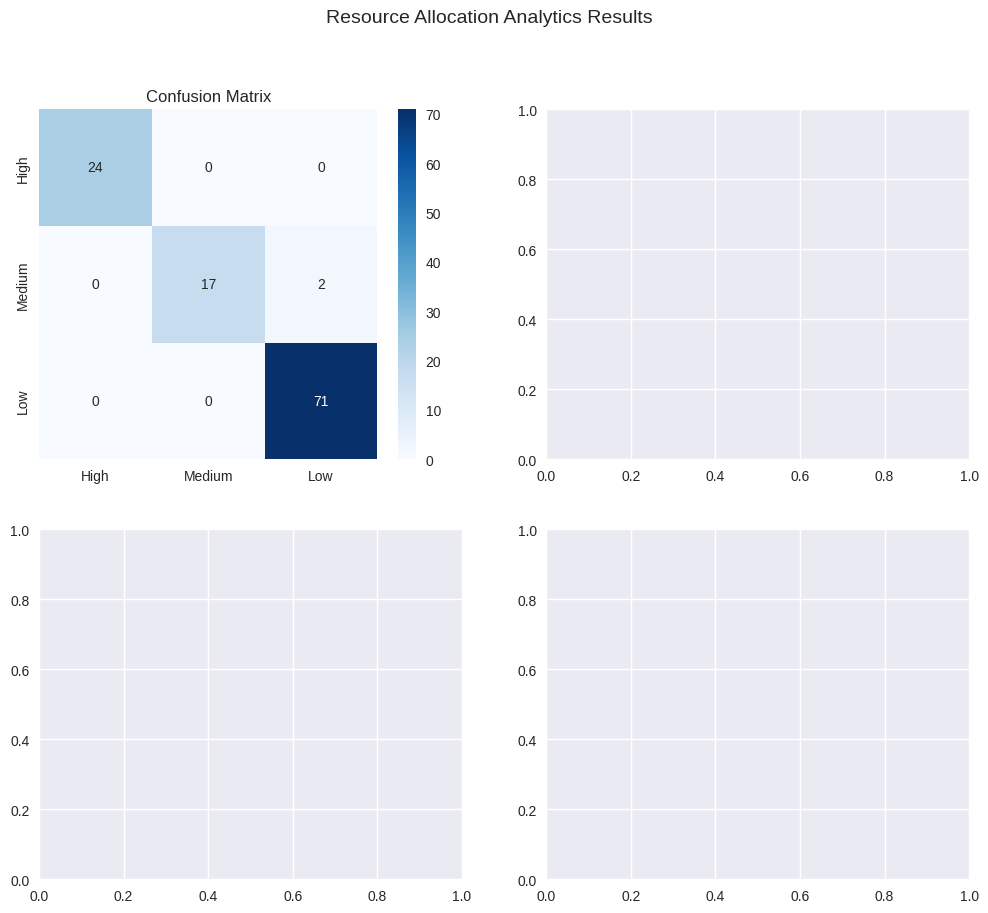

In [10]:
print("\n6. Creating Visualizations...")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Resource Allocation Analytics Results', fontsize=14)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['High', 'Medium', 'Low'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['High', 'Medium', 'Low'], yticklabels=['High', 'Medium', 'Low'],
            ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix')



In [11]:
# Feature Importance
top_features = feature_importance.head(6)
axes[0, 1].barh(range(len(top_features)), top_features['importance'])
axes[0, 1].set_yticks(range(len(top_features)))
axes[0, 1].set_yticklabels([f.replace('mean ', '').replace('worst ', 'w_') for f in top_features['feature']])
axes[0, 1].set_title('Top Feature Importances')


Text(0.5, 1.0, 'Top Feature Importances')

In [13]:
# Performance Metrics
metrics = ['Accuracy', 'F1-Score']
scores = [accuracy, f1]
cv_scores = [cv_accuracy.mean(), cv_f1.mean()]

x = np.arange(len(metrics))
width = 0.35
axes[1, 1].bar(x - width/2, cv_scores, width, label='CV Average', alpha=0.8)
axes[1, 1].bar(x + width/2, scores, width, label='Test Set', alpha=0.8)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Model Performance')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

<Figure size 800x550 with 0 Axes>

In [14]:
print("\n7. SUMMARY AND RECOMMENDATIONS")
print("-" * 40)
print(f"✓ Model Accuracy: {accuracy:.1%}")
print(f"✓ Model F1-Score: {f1:.3f}")
print(f"✓ Cross-validation confirms reliability (±{cv_accuracy.std()*2:.3f})")

priority_dist = y_test.value_counts()
print(f"\nResource Allocation Insights:")
for priority in ['High', 'Medium', 'Low']:
    count = priority_dist.get(priority, 0)
    pct = count / len(y_test) * 100
    print(f"  {priority} Priority: {count} cases ({pct:.1f}%)")

print(f"\nTop Predictors: {', '.join(feature_importance.head(3)['feature'].tolist())}")
print("\n✓ Model ready for deployment!")
print("=" * 50)


7. SUMMARY AND RECOMMENDATIONS
----------------------------------------
✓ Model Accuracy: 98.2%
✓ Model F1-Score: 0.977
✓ Cross-validation confirms reliability (±0.026)

Resource Allocation Insights:
  High Priority: 24 cases (21.1%)
  Medium Priority: 19 cases (16.7%)
  Low Priority: 71 cases (62.3%)

Top Predictors: worst concave points, worst radius, worst perimeter

✓ Model ready for deployment!
